# Imports

In [1]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.4 MB/s eta 0:00:00


In [2]:
import os
import re
import pandas as pd
import numpy as np
from google.colab import drive
import nltk
from nltk.corpus import stopwords

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 100000)
import string
import argparse
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

import tensorflow_hub as hub
import tensorflow_text



# Helper function

In [3]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


# Dataset importing

In [7]:
!gdown https://drive.google.com/uc?id=1U5DQkaFOBmW19Orm2VzAPNJpw-5ipjek

Downloading...
From: https://drive.google.com/uc?id=1U5DQkaFOBmW19Orm2VzAPNJpw-5ipjek
To: /content/dialects_database.db
100% 29.0M/29.0M [00:00<00:00, 196MB/s]


In [8]:
database_file ='dialects_database.db'


In [9]:
con = sqlite3.connect(database_file)

In [10]:
# investigating the db

sql_query1 = """SELECT name FROM sqlite_master
  WHERE type='table';"""

sql_query2="""SELECT * from id_text LIMIT 5;"""
sql_query3="""SELECT * from id_dialect LIMIT 5;"""


cursor = con.cursor()

print('table names')
cursor.execute(sql_query1)
output1=cursor.fetchall()
print(output1)

print('id_text table')
cursor.execute(sql_query2)
output2 = cursor.fetchall()
for row in output2:
  print(row)

print('id_dialect table')
cursor.execute(sql_query3)
output3 = cursor.fetchall()
for row in output3:
  print(row)

con.close()

table names
[('id_text',), ('id_dialect',)]
id_text table
(1009754958479151232, '@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو اختهم او قريبتهم تتعاكس تقولي عليهم من نشاط حقوق المرأة من ردة فعلهم.')
(1009794751548313600, '@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ليا انا ميليشياوي زمان وتوة')
(1019989115490787200, '@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بيرتاح لبنت مختلفة ويلاحظ انها غير كل البنات وبيحس كأنه يعرفها من زمان. بعدين يتزوج وحدة منهن وممكن اثنين ولاثلاثة وتنقلب الرومانسية لعياط وشياط وتهزيب\nand they live happily ever after\nذي اند')
(1035479791758135168, '@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا الانسان يلي يحتاج اهل يخاف منهم علشان يكون محترم هو انسان قليل الادب اصلاً. ثانياً شن ذنب يلي معندهش اب ولا ام ولا خوت ولا خوات؟ يعني اليتيمة متستحقش تتزوج؟ وثالثاً ليش البنت هي بس لازم ادير الف حساب للراجل؟ هي متستحقش يندارلها الف حساب ولا هي عبدة؟')
(1035481122921164800, '@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ازوج بنت يتيمة ولا بنت معندهش خوت. هدي اعصابك وفكين

In [11]:
# joining the two tables by id column
table_1 = 'id_text'
table_2 = 'id_dialect'
sql_query_join = f"""SELECT {table_1}.id, {table_1}.text , {table_2}.dialect
                     FROM {table_1}
                     JOIN {table_2}
                     ON {table_1}.id = {table_2}.id
"""

In [12]:
con2 = sqlite3.connect(database_file)

df = pd.read_sql_query(sql_query_join, con2)

con2.close()

# display the df
df

,id,text,dialect
0,1009754958479151232,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو اختهم او قريبتهم تتعاكس تقولي عليهم من نشاط حقوق المرأة من ردة فعلهم.,LY
1,1009794751548313600,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ليا انا ميليشياوي زمان وتوة,LY
2,1019989115490787200,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بيرتاح لبنت مختلفة ويلاحظ انها غير كل البنات وبيحس كأنه يعرفها من زمان. بعدين يتزوج وحدة منهن وممكن اثنين ولاثلاثة وتنقلب الرومانسية لعياط وشياط وتهزيب\nand they live happily ever after\nذي اند,LY
3,1035479791758135168,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا الانسان يلي يحتاج اهل يخاف منهم علشان يكون محترم هو انسان قليل الادب اصلاً. ثانياً شن ذنب يلي معندهش اب ولا ام ولا خوت ولا خوات؟ يعني اليتيمة متستحقش تتزوج؟ وثالثاً ليش البنت هي بس لازم ادير الف حساب للراجل؟ هي متستحقش يندارلها الف حساب ولا هي عبدة؟,LY
4,1035481122921164800,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ازوج بنت يتيمة ولا بنت معندهش خوت. هدي اعصابك وفكينا من التخلف امتاعك,LY
...,...,...,...
147720,982775354405376000,الناس دي بتنفخ في قربة مقدودة بالدارجي كده البلد دي لو ما الكيزان ديل راحو مافي حياه شريفه في البلد دي لان سبب الفساد والمصائب الموجودة #التطلع_لسودان_افضل,SD
147721,980728852224860160,@Wail_Hamza @amiromer انت عايش وين بره السودان ولا شنو ماشايف البحصل دا,SD
147722,975502734668500992,مااحرم نفسي ميسي حريف ولعاب برضو ..\nمدريدي وافتخر 🇪🇸,SD
147723,980207908641263616,ياخي ديل ماخلو للشيطان وإبليس شي لكن يروحو وين من ربنا ونحن وراك وراك ياكوز ياعفن الأيام معدوده خلاص #تعرف_علي_الكيزان,SD


# EDA

In [13]:
df.head()

,id,text,dialect
0,1009754958479151232,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو اختهم او قريبتهم تتعاكس تقولي عليهم من نشاط حقوق المرأة من ردة فعلهم.,LY
1,1009794751548313600,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ليا انا ميليشياوي زمان وتوة,LY
2,1019989115490787200,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بيرتاح لبنت مختلفة ويلاحظ انها غير كل البنات وبيحس كأنه يعرفها من زمان. بعدين يتزوج وحدة منهن وممكن اثنين ولاثلاثة وتنقلب الرومانسية لعياط وشياط وتهزيب\nand they live happily ever after\nذي اند,LY
3,1035479791758135168,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا الانسان يلي يحتاج اهل يخاف منهم علشان يكون محترم هو انسان قليل الادب اصلاً. ثانياً شن ذنب يلي معندهش اب ولا ام ولا خوت ولا خوات؟ يعني اليتيمة متستحقش تتزوج؟ وثالثاً ليش البنت هي بس لازم ادير الف حساب للراجل؟ هي متستحقش يندارلها الف حساب ولا هي عبدة؟,LY
4,1035481122921164800,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ازوج بنت يتيمة ولا بنت معندهش خوت. هدي اعصابك وفكينا من التخلف امتاعك,LY


In [14]:
# basic stats
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147725 entries, 0 to 147724
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       147725 non-null  int64 
 1   text     147725 non-null  object
 2   dialect  147725 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.4+ MB


In [15]:
# Checking for duplicates
df.duplicated("text").sum()

0

In [16]:
# checking for nulls
df.isnull().sum()

id         0
text       0
dialect    0
dtype: int64

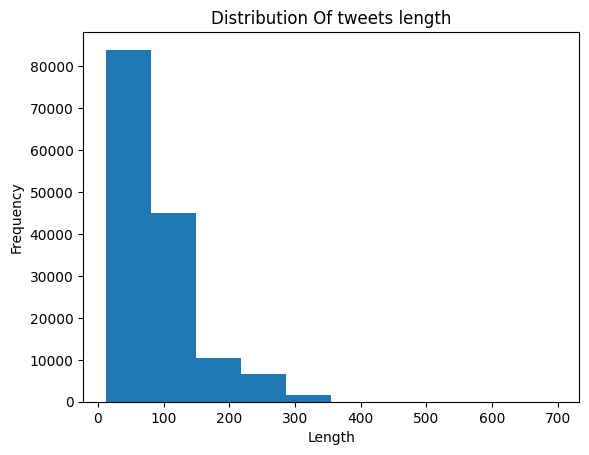

In [17]:
# length of tweets distribution [chars]

plt.hist(df['text'].apply(len))
plt.title('Distribution Of tweets length')
plt.ylabel('Frequency')
plt.xlabel('Length')

plt.show()

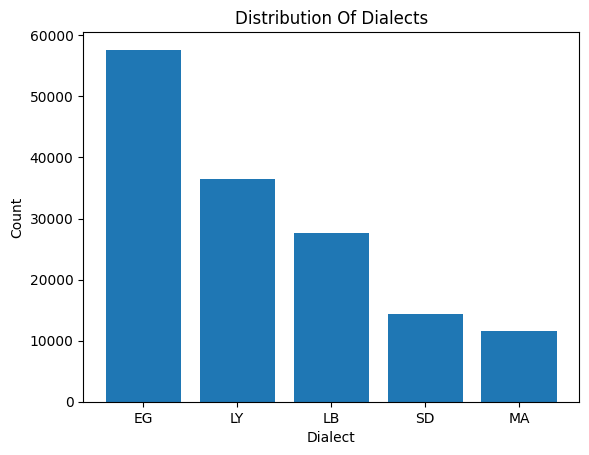

In [18]:
# distribution of dialects
dialect_counts = df['dialect'].value_counts()

plt.bar(dialect_counts.index,dialect_counts )
plt.title('Distribution Of Dialects')
plt.ylabel('Count')
plt.xlabel('Dialect')

plt.show()

In [19]:
# taking a sample from the data to investigate the required preprocessing steps
df.sample(10)

,id,text,dialect
108454,1111892027850002432,لما توقع وما حدا يشوفك☺️\nصدقني أن الفرحة أكبر من الالم \n#بتكملها_جمباز😂😂😂😂,LB
143627,1172934171209191424,@sudania1000 المفروض قائمة التهم تكون مجهزاها قحت وخاته الملف قدام النيابه والدعواي المرفوعه ضده كلها اخلص من دعوه أخش في دعوه المحاميين ديل دفاع بدافعو عنه بس,SD
10182,786837476333740032,@_HAMAN @KhalilLarbah ههههههه خليل رزيل مايتحشمش,LY
6147,1171402720282066944,نبات نحدث في المرايا مش نسمع في حديث بنية,LY
59954,1057329999760498816,@Hadeezz اسمها ايه الحلقة دي عشان اشوفها 😂😂؟,EG
104493,1125036663133081600,@alatrozy الملوخيه عندنا هنا بيسموها green soup وتعامل معامله الشوربه والعدس ايضا lentils شوربه بس بديل الشاي ممكن كوبايه شوربه عدس عندما يكون الجو صقيع فكره,EG
84345,1078193035106762752,@lolaasem14 الف سلامه عليكي💐\nانا عايز حقي ناشف 😁,EG
13171,827277701408923648,@Perhapsme_ ممكن انتي اللي جيتي في المكان الغلط ..,LY
96125,1130602263523790848,مصطفى حسنى مش fake هو بياكل عيش بس وقرر يعبى الدين فى حلقات ويلفه بشوية سهوكة عشان يعرف يبيع 😂😂😂 https://t.co/TIcFHerl6L,EG
91413,713845295327657984,تنيهده بتقول ألف كلمه ساكته..,EG


# Data preprocessing :

1. removing stopwords
2. removing links
3. removing usernames
4. removing English words
5. removing numbers  
6. removing punctiation
7. removing Arabic diacritics
8. removing redunduent chars like `ههههههههه`
9. removing emojies
10. remove special chars  
11. remove extra whitespaces
12. normalizing the arabic letters


In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words('arabic'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

raw_text = " هنا القاهرة "
preprocessed_text = remove_stopwords(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before:  هنا القاهرة 
After : القاهرة


In [22]:
def remove_links(text):
    URL_REGEX =r"(http[s]?://(?:[a-zA-Z]|[0-9]|[$-@.&+]|[!*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)|(www\.[a-zA-Z0-9\-\._~:/?#\[\]@!$&'()*+,;=%]+)"
    text = re.sub(URL_REGEX, '', text)
    return text

raw_text = "صباح الخير  www.google.com https://perfect-match.com https://t.co/hFT5eQ9Nlj	https://t.co/AQDKPXo3ky	"
preprocessed_text = remove_links(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: صباح الخير  www.google.com https://perfect-match.com https://t.co/hFT5eQ9Nlj	https://t.co/AQDKPXo3ky	
After : صباح الخير    		


In [23]:
def remove_usernames(text):
  text= re.sub(r'@\w+','',text)
  return text

raw_text = "@NehmatSabeh @Abbadmoh10 يا ريت الاوفياء راحو ع سعودية قبل فرنسا 👌😂"
preprocessed_text = remove_usernames(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: @NehmatSabeh @Abbadmoh10 يا ريت الاوفياء راحو ع سعودية قبل فرنسا 👌😂
After :   يا ريت الاوفياء راحو ع سعودية قبل فرنسا 👌😂


In [24]:
def remove_english(text):
  text=re.sub(r"[a-zA-Z]+", '', text)
  return text

raw_text = "May00772264932 @jamil_el_sayyed هيدا زعيم العصابة، وبردو بيسهر ليتابع عمليات السرقة لأن بيخاف يسرقوه زلمه كمان"
preprocessed_text = remove_english(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: May00772264932 @jamil_el_sayyed هيدا زعيم العصابة، وبردو بيسهر ليتابع عمليات السرقة لأن بيخاف يسرقوه زلمه كمان
After : 00772264932 @__ هيدا زعيم العصابة، وبردو بيسهر ليتابع عمليات السرقة لأن بيخاف يسرقوه زلمه كمان


In [25]:
def remove_numbers(text):
  text=re.sub(r"\d+", '', text)
  return text

raw_text = "00772264932 @__ هيدا زعيم العصابة، وبردو بيسهر ليتابع عمليات السرقة لأن بيخاف يسرقوه زلمه كمان"
preprocessed_text = remove_numbers(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: 00772264932 @__ هيدا زعيم العصابة، وبردو بيسهر ليتابع عمليات السرقة لأن بيخاف يسرقوه زلمه كمان
After :  @__ هيدا زعيم العصابة، وبردو بيسهر ليتابع عمليات السرقة لأن بيخاف يسرقوه زلمه كمان


In [26]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

In [27]:
def remove_punctuation(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

raw_text = "@__  # & % * ( ) { } ! ` هيدا زعيم العصابة، وبردو بيسهر ليتابع عمليات السرقة لأن بيخاف يسرقوه زلمه كمان"
preprocessed_text = remove_punctuation(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: @__  # & % * ( ) { } ! ` هيدا زعيم العصابة، وبردو بيسهر ليتابع عمليات السرقة لأن بيخاف يسرقوه زلمه كمان
After :             هيدا زعيم العصابة وبردو بيسهر ليتابع عمليات السرقة لأن بيخاف يسرقوه زلمه كمان


In [28]:
def remove_diacritics(text):
  arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida

                         """, re.VERBOSE)
  return re.sub(arabic_diacritics, '', text)

raw_text = " ( بِسْمِ اللَّـهِ الرَّحْمَـٰنِ الرَّحِيمِ )"
preprocessed_text = remove_diacritics(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')


Before:  ( بِسْمِ اللَّـهِ الرَّحْمَـٰنِ الرَّحِيمِ )
After :  ( بسم الله الرحمٰن الرحيم )


In [29]:
def removing_redundant_chars(text):
  text=re.sub(r"(.)\1{2,}", r'\1\1', text)
  return text

raw_text = " هههههههههه وااااو "
preprocessed_text = removing_redundant_chars(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')


Before:  هههههههههه وااااو 
After :  هه وااو 


In [30]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

raw_text = " مساء الخير 😉😂😘	"
preprocessed_text = remove_emojis(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before:  مساء الخير 😉😂😘	
After :  مساء الخير 	


In [31]:
def remove_special_chars(text):
  # Regex to keep only Arabic letters
  text= re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF]+', ' ', text)
  return text

raw_text = "  ðŸŒŽðŸŒ  مساء الخير 😉😂😘	"
preprocessed_text = remove_special_chars(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before:   ðŸŒŽðŸŒ  مساء الخير 😉😂😘	
After :  مساء الخير 


In [32]:
def remove_extra_whitespaces(text):
  text= re.sub(r'\s+', ' ', text)
  return text.strip()


raw_text = "       مساء    الخير "
preprocessed_text = remove_extra_whitespaces(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before:        مساء    الخير 
After : مساء الخير


In [33]:
def normalize_chars(text):
    preprocessed_text = re.sub("[إأآا]", "ا", text)
    preprocessed_text = re.sub("ى", "ي", preprocessed_text)
    preprocessed_text = re.sub("ؤ", "ء", preprocessed_text)
    preprocessed_text = re.sub("ئ", "ء", preprocessed_text)
    preprocessed_text = re.sub("ة", "ه", preprocessed_text)
    preprocessed_text = re.sub("گ", "ك", preprocessed_text)
    preprocessed_text = re.sub("ڤ", "ف", preprocessed_text)
    preprocessed_text = re.sub("چ", "ج", preprocessed_text)
    preprocessed_text = re.sub("ژ", "ز", preprocessed_text)
    preprocessed_text = re.sub("پ", "ب", preprocessed_text)
    return preprocessed_text

raw_text ="أإ   ي ى  ه ة "
preprocessed_text = normalize_chars(raw_text)

print(f'Before: {raw_text}\n')
print(f'After : {preprocessed_text}')

Before: أإ   ي ى  ه ة 

After : اا   ي ي  ه ه 


In [34]:
# Applying preprocessing

def preprocess(text):
  #stop_words
  text = remove_stopwords(text)

  #user_names
  text = remove_usernames(text)

  #emojies
  text = remove_emojis(text)

  #numbers
  text = remove_numbers(text)

  #links
  text = remove_links(text)

  # English
  text= remove_english(text)

  #diacritics
  text=remove_diacritics(text)

  # special chars
  text=remove_special_chars(text)

  # punctuation
  text=remove_punctuation(text)

  #white_space
  text = remove_extra_whitespaces(text)

  #normalizeChars
  text=normalize_chars(text)

  #redundant charachters
  text = removing_redundant_chars(text)

  return text


In [35]:
df_preprocessed = df.copy()
df_preprocessed['text']=df_preprocessed['text'].apply(preprocess)
df_preprocessed= df_preprocessed.drop('id',axis=1)
df_preprocessed

,text,dialect
0,قليلين ادب ومنافقين اختهم او قريبتهم تتعاكس تقولي عليهم نشاط حقوق المراه رده فعلهم,LY
1,الليبيين متقلبين بالنسبه ليا انا ميليشياوي زمان وتوه,LY
2,تانيه شاب ليبي بيرتاح لبنت مختلفه ويلاحظ انها البنات وبيحس كانه يعرفها زمان بعدين يتزوج وحده منهن وممكن ولاثلاثه وتنقلب الرومانسيه لعياط وشياط وتهزيب اند,LY
3,رانيا عقليتك متخلفه اولا الانسان يلي يحتاج اهل يخاف منهم علشان يكون محترم انسان قليل الادب اصلا ثانيا شن ذنب يلي معندهش اب ام خوت خوات يعني اليتيمه متستحقش تتزوج وثالثا ليش البنت لازم ادير الف حساب للراجل متستحقش يندارلها الف حساب عبده,LY
4,شكلك متعقده علشان الراجل تحبيه ازوج بنت يتيمه بنت معندهش خوت هدي اعصابك وفكينا التخلف امتاعك,LY
...,...,...
147720,الناس دي بتنفخ قربه مقدوده بالدارجي كده البلد دي الكيزان ديل راحو مافي حياه شريفه البلد دي لان سبب الفساد والمصاءب الموجوده التطلع لسودان افضل,SD
147721,انت عايش وين بره السودان شنو ماشايف البحصل دا,SD
147722,مااحرم نفسي ميسي حريف ولعاب برضو مدريدي وافتخر,SD
147723,ياخي ديل ماخلو للشيطان وابليس شي يروحو وين ربنا ونحن وراك وراك ياكوز ياعفن الايام معدوده خلاص تعرف علي الكيزان,SD


## encoding the label features


In [36]:
label_encoder = LabelEncoder()
labels_encoded =  label_encoder.fit_transform(df_preprocessed['dialect'].to_numpy())
labels_encoded

array([2, 2, 2, ..., 4, 4, 4])

In [37]:
#getting  class anames from label encoder instance
class_names = label_encoder.classes_
class_names

array(['EG', 'LB', 'LY', 'MA', 'SD'], dtype=object)

In [38]:
id2label = dict(enumerate(class_names))
id2label

{0: 'EG', 1: 'LB', 2: 'LY', 3: 'MA', 4: 'SD'}

## splitting the data into train and val splits

In [39]:
X = df_preprocessed['text']
y = labels_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle= True, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((118180,), (29545,), (118180,), (29545,))

# Modeling expriments

## Modeliing Checkpoint

In [53]:
# function to implement a model checkpoint with a specific file name
def create_model_checkpoint(model_name, save_path='model_expriments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_path,model_name),
                                            monitor = 'val_loss',
                                            verbose= 0,
                                            save_best_only = True )

## Embedding Layer

In [40]:
# finding the average tweets lengths
tweet_lens = [len(sentence.split()) for sentence in X_train]
avg_tweet_len = np.mean(tweet_lens)
avg_tweet_len

11.685674394990691

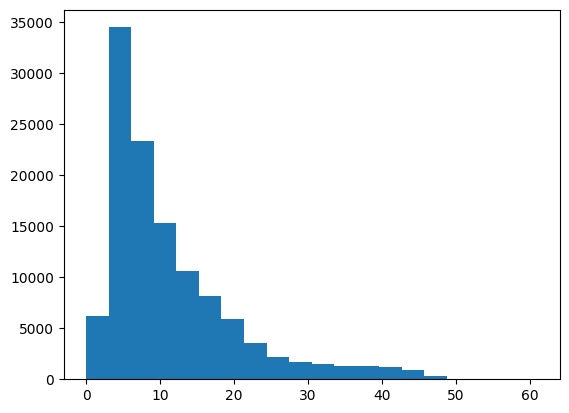

In [41]:
# distribution on len [tokens]
plt.hist(tweet_lens, bins=20);

In [42]:
# finding the length that covers 95% of the trainig data
output_seq_len = int(np.percentile(tweet_lens, 95))
output_seq_len

32

In [43]:
max_length = 32
max_vocab_length = 120000
text_vectorizer = TextVectorization(max_tokens=max_vocab_length, output_mode="int", output_sequence_length=max_length)

In [44]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [45]:
# Getting insigths from the vectorizer
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 120000
Top 5 most common words: ['', '[UNK]', 'اللي', 'مش', 'انا']
Bottom 5 least common words: ['ماشوفنهاش', 'ماشوفتهوش', 'ماشوفتهاش', 'ماشوفته', 'ماشوفتك']


In [46]:
embedding = layers.Embedding(input_dim = max_vocab_length , output_dim = 128, input_length = max_length)
embedding

In [47]:
random_tweet = random.choice(X_train)
print(f'Tweet before embeding: {random_tweet}\
        \n\n Tweet after embedding:')

embedded_tweet = embedding(text_vectorizer(random_tweet))
embedded_tweet

Tweet before embeding: متقولش حاجه فصلتني ضحك        

 Tweet after embedding:


<tf.Tensor: shape=(32, 128), dtype=float32, numpy=
array([[-0.02036203,  0.00525369, -0.02690827, ...,  0.03534878,
        -0.02653505,  0.04229068],
       [-0.00940382, -0.03401755,  0.00511881, ...,  0.02252838,
        -0.02749261,  0.01575241],
       [ 0.04122046,  0.04865954, -0.02438505, ..., -0.01564407,
         0.0156245 , -0.0375474 ],
       ...,
       [-0.03606988,  0.03652189,  0.03572948, ...,  0.02999398,
         0.00606853,  0.03292895],
       [-0.03606988,  0.03652189,  0.03572948, ...,  0.02999398,
         0.00606853,  0.03292895],
       [-0.03606988,  0.03652189,  0.03572948, ...,  0.02999398,
         0.00606853,  0.03292895]], dtype=float32)>

## Model 1 : baseline TF-IDF Multinomial Naive Bayes classifer

In [48]:
#pipeline
model_0 = Pipeline(
    [("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())]
)

# fit pipeline to training data
model_0.fit(X= X_train,
            y= y_train)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [49]:
# Evaluating baseline on validation data
model_0.score(X= X_val,
            y= y_val)

0.7227957353190049

In [50]:
# making predictions
baseline_preds = model_0.predict(X_val)

# calculating baseline results
baseline_results = calculate_results(y_true= y_val, y_pred= baseline_preds)
baseline_results

{'accuracy': 72.27957353190048,
 'precision': 0.799596153966949,
 'recall': 0.7227957353190049,
 'f1': 0.6917543858114114}

## Model 2 : LSTM

In [51]:
# since the dataset is imaplanced we utilize the classweigths so the model not baiswed towards the heigest class
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
class_weights = dict(enumerate(np.squeeze(class_weights)))

In [52]:
# one hot encode labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = one_hot_encoder.transform(y_val.reshape(-1, 1))

y_train_encoded

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [54]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(1,), dtype= "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs, name='LSTM_model')

#compile
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['categorical_accuracy'])

#fitting
model_2_history = model_2.fit(X_train, y_train_encoded, shuffle=True,
                    epochs=50,
                    batch_size = 128,
                    validation_data = (X_val, y_val_encoded),
                    callbacks=[ create_model_checkpoint(model_name=model_2.name),
                        EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=3, verbose=1)],
                    class_weight=class_weights)

Epoch 1/50
924/924 [==============================] - 60s 58ms/step - loss: 0.4321 - categorical_accuracy: 0.6824 - val_loss: 0.5772 - val_categorical_accuracy: 0.7990
Epoch 2/50
924/924 [==============================] - 21s 23ms/step - loss: 0.1954 - categorical_accuracy: 0.8746 - val_loss: 0.5477 - val_categorical_accuracy: 0.8130
Epoch 3/50
924/924 [==============================] - 15s 16ms/step - loss: 0.1138 - categorical_accuracy: 0.9300 - val_loss: 0.5923 - val_categorical_accuracy: 0.8110
Epoch 4/50
924/924 [==============================] - 13s 14ms/step - loss: 0.0776 - categorical_accuracy: 0.9531 - val_loss: 0.7355 - val_categorical_accuracy: 0.8048
Epoch 5/50
924/924 [==============================] - 14s 15ms/step - loss: 0.0576 - categorical_accuracy: 0.9652 - val_loss: 0.7650 - val_categorical_accuracy: 0.8005
Epoch 5: early stopping


In [55]:
model_2.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 32, 128)           15360000  
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                        

In [57]:
#loading the best model making predictions with the model
model_2 = tf.keras.models.load_model('model_expriments/LSTM_model')
model_2_pred_probs = model_2.predict(X_val)
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)

model_2_results = calculate_results(y_true=y_val, y_pred= model_2_preds)
model_2_results

924/924 [==============================] - 4s 3ms/step


{'accuracy': 81.2997123032662,
 'precision': 0.8173147855455944,
 'recall': 0.812997123032662,
 'f1': 0.8123848101178595}

## Model 3 : GRU

In [62]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(1,), dtype= "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64,)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name='GRU_model')

#compile
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['categorical_accuracy'])

#fitting
model_3_history = model_3.fit(X_train, y_train_encoded, shuffle=True,
                    epochs=50,
                    batch_size = 128,
                    validation_data = (X_val, y_val_encoded),
                    callbacks=[create_model_checkpoint(model_name=model_3.name),
                               EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=3, verbose=1 ,  restore_best_weights=True)],
                    class_weight=class_weights)

Epoch 1/50
924/924 [==============================] - 106s 52ms/step - loss: 0.1508 - categorical_accuracy: 0.8905 - val_loss: 0.8708 - val_categorical_accuracy: 0.7904
Epoch 2/50
924/924 [==============================] - 17s 18ms/step - loss: 0.0277 - categorical_accuracy: 0.9826 - val_loss: 0.9734 - val_categorical_accuracy: 0.7913
Epoch 3/50
924/924 [==============================] - 14s 15ms/step - loss: 0.0202 - categorical_accuracy: 0.9873 - val_loss: 1.0873 - val_categorical_accuracy: 0.7843
Epoch 4/50
924/924 [==============================] - 13s 14ms/step - loss: 0.0171 - categorical_accuracy: 0.9887 - val_loss: 1.1776 - val_categorical_accuracy: 0.7764
Epoch 5/50
924/924 [==============================] - 13s 15ms/step - loss: 0.0147 - categorical_accuracy: 0.9901 - val_loss: 1.3414 - val_categorical_accuracy: 0.7772
Epoch 5: early stopping


In [64]:
# making predictions with the model
model_3 = tf.keras.models.load_model('model_expriments/GRU_model')
model_3_pred_probs = model_3.predict(X_val)
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)

model_3_results = calculate_results(y_true=y_val, y_pred= model_3_preds)
model_3_results

924/924 [==============================] - 7s 6ms/step


{'accuracy': 79.03875444237603,
 'precision': 0.792097018862215,
 'recall': 0.7903875444237604,
 'f1': 0.7908668336337737}

## Model 4 : Bidirectional RNN

In [65]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(1,), dtype= "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_4 = tf.keras.Model(inputs, outputs, name='bidirectional_model')

#compile
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['categorical_accuracy'])

#fitting
model_4_history = model_4.fit(X_train, y_train_encoded, shuffle=True,
                    epochs=10,
                    batch_size = 128,
                    validation_data = (X_val, y_val_encoded),
                    callbacks=[create_model_checkpoint(model_name=model_4.name),
                        EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=3, verbose=1 ,  restore_best_weights=True)],
                    class_weight=class_weights)

Epoch 1/10
924/924 [==============================] - 64s 64ms/step - loss: 0.0840 - categorical_accuracy: 0.9453 - val_loss: 0.8925 - val_categorical_accuracy: 0.7902
Epoch 2/10
924/924 [==============================] - 19s 20ms/step - loss: 0.0265 - categorical_accuracy: 0.9838 - val_loss: 1.0095 - val_categorical_accuracy: 0.7894
Epoch 3/10
924/924 [==============================] - 17s 19ms/step - loss: 0.0197 - categorical_accuracy: 0.9873 - val_loss: 1.1201 - val_categorical_accuracy: 0.7837
Epoch 4/10
924/924 [==============================] - 15s 16ms/step - loss: 0.0160 - categorical_accuracy: 0.9893 - val_loss: 1.2611 - val_categorical_accuracy: 0.7788
Epoch 4: early stopping


In [67]:
# making predictions with the model
model_4 = tf.keras.models.load_model('model_expriments/bidirectional_model')
model_4_pred_probs = model_4.predict(X_val)
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)

model_4_results = calculate_results(y_true=y_val, y_pred= model_4_preds)
model_4_results

924/924 [==============================] - 5s 4ms/step


{'accuracy': 79.01844643763751,
 'precision': 0.791626849462289,
 'recall': 0.790184464376375,
 'f1': 0.7906990501847185}

## Model 5 : Hybrid Model  `token and charcter embeddings`

### Creating a char level vectorizer and embedding layers

In [68]:
# creating a charcter level tokenizer
def split_chars(text):
   return " ".join(list(text))

In [69]:
#testing the function out on a random tweet
split_chars(random.choice(X_train))

'ك ا ب ت ن   م د ح ت   ش ل ب ي   ا خ ط ا   خ ط ا   ر ه ي ب   ق ا ل   ا ن ه   م ش   ه ي ع ل ق   م ا ت ش   ا ل ق م ه   ا ل ا ه ل ي   و ا ل ز م ا ل ك   ل ا ن   ا ل ف ر ق   ا ل ف ر ي ق ي ن   ن ق ط ه   و د ه   ا ه ا ن ه   ل ل ز م ا ل ك   و ج م ا ه ي ر ه   ا ل ل ي   ز ع ل و ا   و د ه   ح ق ه م   ش ل ب ي   ي ع ت ذ ر   ف و ر ا   ل ج م ه و ر   ا ل ز م ا ل ك   ب س ب ب   ا ل خ ط ا   ا ل ر ه ي ب   ل ا ن   ا ل ف ر ق   ب ي ن ه م   ن ق ط ه   م ش'

In [70]:
train_chars = [split_chars(tweet)  for tweet in X_train]
val_chars = [split_chars(tweet)  for tweet in X_val]

In [71]:
# Finding out the average CHar length in the tweets
char_lens =[len(tweet) for tweet in X_train]
avg_tweet_len = np.mean(char_lens)
avg_tweet_len

64.49225757319343

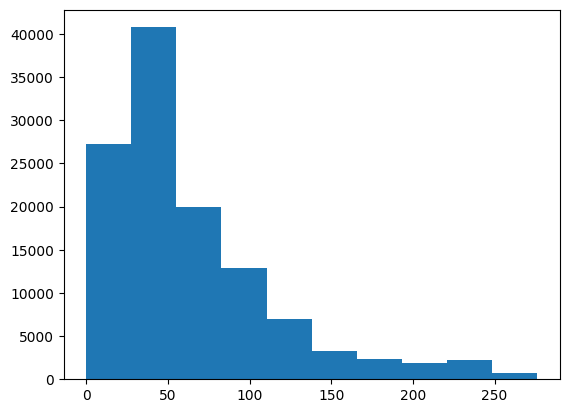

In [72]:
plt.hist(char_lens);

In [73]:
# finding the len that covers 95% if the trainign dataset
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

180

In [74]:
arabic_alphabet = 'ابتثجحخدذرزسشصضطظعغفقكلمنهوي'
NUM_CHAR_TOKENS = len(arabic_alphabet)+ 2 #one for space and the other for OOV token"out of vocab ["UNK"]"

In [75]:
char_vectorizer = TextVectorization(
    max_tokens= NUM_CHAR_TOKENS, # vocabulary size
    output_sequence_length= output_seq_char_len, #desired output length in the vectorized chars
    name = "char_vectorizer"
)

In [76]:
# Adapting to train chars
char_vectorizer.adapt(train_chars)

In [77]:
# investigating char vocab
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of Vocab chars : {len(char_vocab)}")
print(f"Most common chars in Vocab : {char_vocab[:5]}")
print(f"Least common chars in Vocab : {char_vocab[-5:]}")

Number of Vocab chars : 30
Most common chars in Vocab : ['', '[UNK]', 'ا', 'ل', 'ي']
Least common chars in Vocab : ['ض', 'غ', 'ء', 'ذ', 'ث']


In [78]:
# Making embedding layer
char_embed = layers.Embedding(
    input_dim= len(char_vocab),
    output_dim=30,
    mask_zero= True,
    name = "char_embedding"
)

### Model building

In [79]:
tf.random.set_seed(42)

#1. Token inputs model
token_inputs = layers.Input(shape=(1,), dtype ='string', name='token_input')
x = text_vectorizer(token_inputs)
x = embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
token_model = tf.keras.Model(token_inputs,x)


#2. Char inputs model
char_inputs = layers.Input(shape=(1,),dtype='string', name='char_inputs')
x = char_vectorizer(char_inputs)
x = char_embed(x)
x = layers.Bidirectional(layers.LSTM(32))(x)
char_model = tf.keras.Model(char_inputs, x)

# 3. concatinating token and char inputs [hybrid token emedding]
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4.creating output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(64, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)


# 5. construct model with char and token inputs
hybrid_model= tf.keras.Model(inputs = [token_model.input, char_model.input],
                        outputs= output_layer,
                        name="Hybrid_token_and_char_embeddings_Model")

#compile
hybrid_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['categorical_accuracy'])


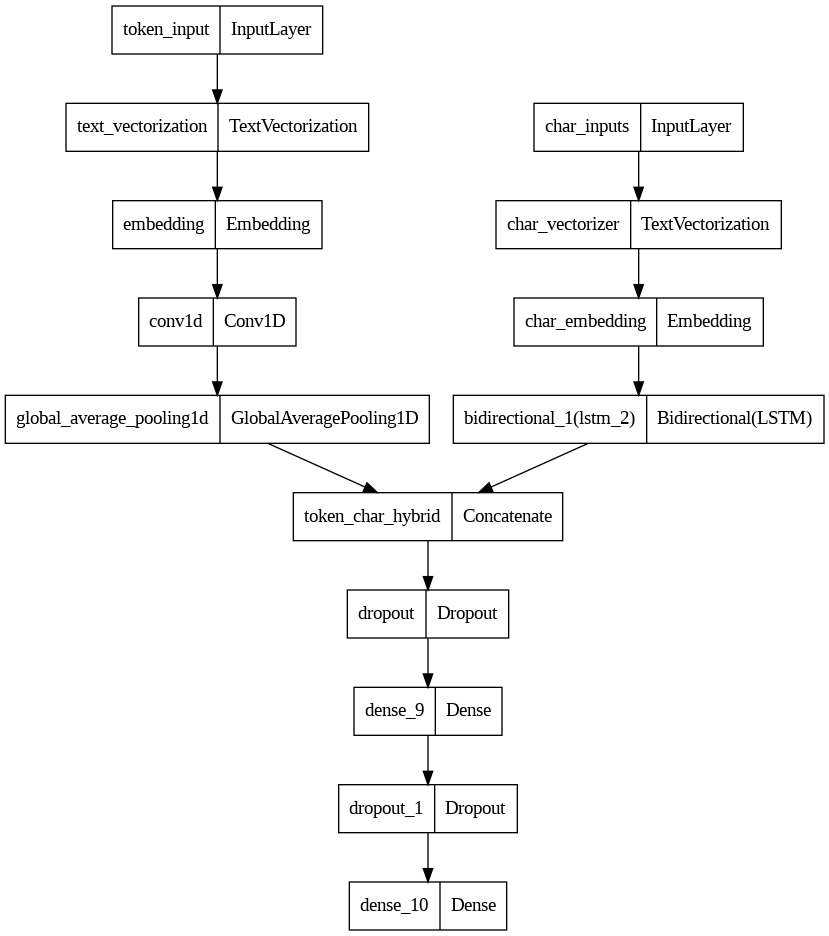

In [81]:
from keras.utils import plot_model
plot_model(hybrid_model)

In [82]:
train_chars = np.array(train_chars)
val_chars = np.array(val_chars)

In [83]:
#fitting
hybrid_model_history = hybrid_model.fit([X_train,train_chars], y_train_encoded, shuffle=True,
                    epochs=10,
                    batch_size = 128,
                    validation_data = ([X_val,val_chars], y_val_encoded),
                    callbacks=[create_model_checkpoint(model_name=hybrid_model.name),
                        EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=3, verbose=1 ,  restore_best_weights=True)],
                    class_weight=class_weights)

Epoch 1/10
924/924 [==============================] - 170s 167ms/step - loss: 0.1550 - categorical_accuracy: 0.9040 - val_loss: 0.7245 - val_categorical_accuracy: 0.7980
Epoch 2/10
924/924 [==============================] - 87s 94ms/step - loss: 0.0646 - categorical_accuracy: 0.9620 - val_loss: 0.8326 - val_categorical_accuracy: 0.8025
Epoch 3/10
924/924 [==============================] - 83s 90ms/step - loss: 0.0499 - categorical_accuracy: 0.9704 - val_loss: 0.9420 - val_categorical_accuracy: 0.7972
Epoch 4/10
924/924 [==============================] - 83s 90ms/step - loss: 0.0430 - categorical_accuracy: 0.9740 - val_loss: 1.0069 - val_categorical_accuracy: 0.7933
Epoch 5/10
924/924 [==============================] - 85s 92ms/step - loss: 0.0377 - categorical_accuracy: 0.9764 - val_loss: 1.1320 - val_categorical_accuracy: 0.7963
Epoch 5: early stopping


In [84]:
# making predictions with the model
hybrid_model = tf.keras.models.load_model('model_expriments/Hybrid_token_and_char_embeddings_Model')
hybrid_model_pred_probs = hybrid_model.predict([X_val,val_chars])
hybrid_model_preds = tf.argmax(hybrid_model_pred_probs,axis=1)

hybrid_model_results = calculate_results(y_true=y_val, y_pred= hybrid_model_preds)
hybrid_model_results

924/924 [==============================] - 13s 12ms/step


{'accuracy': 79.8036892875275,
 'precision': 0.7984702852666946,
 'recall': 0.798036892875275,
 'f1': 0.7981820462692387}

# Comparing Models results

In [85]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "Hybrid Model": hybrid_model_results,
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.279574,0.799596,0.722796,0.691754
lstm,81.299712,0.817315,0.812997,0.812385
gru,79.038754,0.792097,0.790388,0.790867
bidirectional,79.018446,0.791627,0.790184,0.790699
Hybrid Model,79.803689,0.798470,0.798037,0.798182


In [86]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

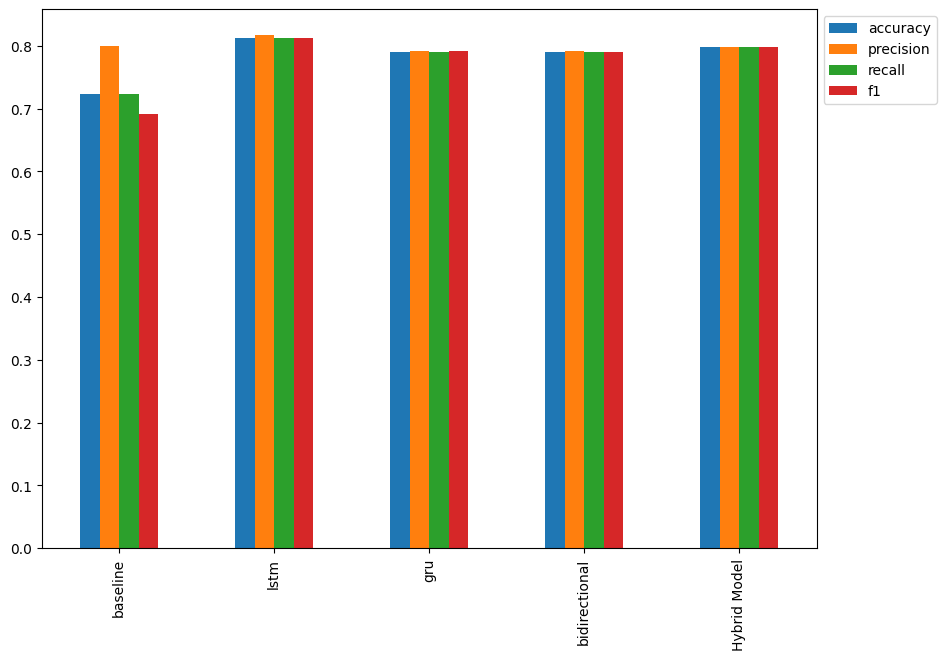

In [87]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

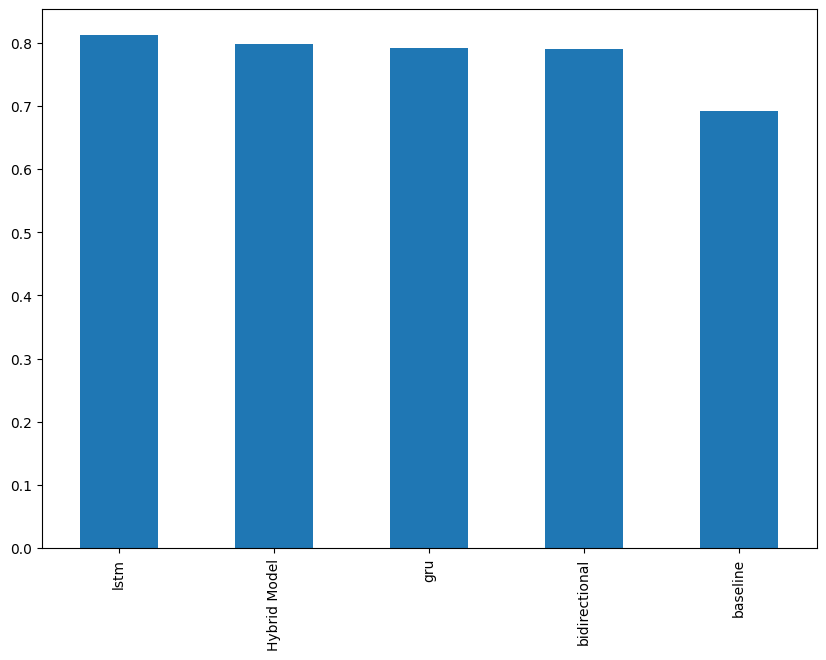

In [88]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Saving the model

In [89]:
drive_path = '/content/drive/MyDrive/Arabic dialect'
model_2.save(drive_path +'/lstm_model')

# Testing out the loaded model

In [90]:
loaded_model = load_model('/content/drive/MyDrive/Arabic dialect/lstm_model')


In [91]:
# tweets from the wild
tweets = ['فينك يا بنتي من الصبح','تقبريني اشتقتلك','خيرك تشبحلي']
ground_truth = [0,1,2]

for tweet in tweets:
  tweet = preprocess(tweet)

predictions = loaded_model.predict(tweets)
predicted_classes = np.argmax(predictions, axis=1)

# mapping to labels
predicted_labels = [id2label[id] for id in predicted_classes]
ground_truth_labels = [id2label[id] for id in ground_truth]

for tweet, prediction, truth in zip(tweets, predicted_labels, ground_truth_labels):
    print(f"Tweet: '{tweet}'\nPredicted Country: {prediction}, Actual Country: {truth}\n")


1/1 [==============================] - 1s 747ms/step
Tweet: 'فينك يا بنتي من الصبح'
Predicted Country: EG, Actual Country: EG

Tweet: 'تقبريني اشتقتلك'
Predicted Country: LB, Actual Country: LB

Tweet: 'خيرك تشبحلي'
Predicted Country: LY, Actual Country: LY

